# 1. mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. setup
در این بخش پکیج های مورد نیاز را در صورت نیاز نصب می کنیم. آن ها را ایمپورت میکنیم و متغیرهایی که در سراسر نوتبوک مورد نیاز است را مقداردهی می کنیم

## 1. installs

In [ ]:
!pip install catboost
!pip install xgboost
# !pip uninstall scikit-learn
!pip install scikit-learn==0.24.2
# !pip uninstall imblearn
# !pip install -U imbalanced-learn
# !pip install imblearn

In [ ]:
# !pip uninstall imblearn

In [ ]:
# !pip install -U imbalanced-learn

## 2. imports

In [8]:
# ------------------------------ GENERAL ITEMS ----------------------------#
import pickle
import math
import joblib
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# ------------------------------ CLASSIFIERS ----------------------------#
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
# ------------------------------ REGRESSORS ----------------------------#
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# ------------------------------ METRICS ----------------------------#
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import r2_score
from sklearn import metrics
# ------------------------------ UTILS ----------------------------#
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# ------------------------------ RESAMPLING ----------------------------#
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE

## 3. global variables

In [13]:
raw_data_csv_path = '../content/drive/MyDrive/wifi_project/2021_08_09-00_52_27_modified.csv'
live_samples_path = '../content/drive/MyDrive/wifi_project/live_samples.txt'
models_dir = '../content/drive/MyDrive/wifi_project/models'

mac_remove_list = [
                   '00:1f:fb:ea:46:d9', #iphone
                   '3a:f6:43:0d:98:00', #irancell
                   'b8:76:3f:5a:77:4f'  # i dont know
                   ]

# merge data files

In [ ]:
# file1_40 = pd.read_csv('../content/drive/MyDrive/FinalProject/2021_08_25-22_48_12_modified.csv').iloc[:,1:]
# file2 = pd.read_csv('../content/drive/MyDrive/FinalProject/2021_08_09-00_52_27_modified.csv').iloc[:,1:]
# file3 = pd.read_csv('../content/drive/MyDrive/FinalProject/2021_08_16-22_01_40_modified.csv').iloc[:,1:]
# file1_40['x'] = file1_40.x.apply(lambda v:(v/40)*60)
# file1_40['y'] = file1_40.y.apply(lambda v:(v/40)*60)

# for col in file1_40.columns:
#     if col not in list(file2.columns): file1_40.drop(col, axis=1, inplace=True)

# all_data = pd.concat([file1_40,
#                       file2,
#                       file3
#                       ], axis=0)

# all_data.to_csv('../content/drive/MyDrive/FinalProject/data.csv')

# 3. import data
داده های خام را ایمپورت کنید

## 1. load

In [14]:
data = pd.read_csv(raw_data_csv_path).iloc[:,1:]
data.shape

(34780, 24)

## 2. preview

In [15]:
data.sample(5)

,x,y,date_time,00:1f:fb:ea:46:d9,3a:f6:43:0d:98:00,44:d9:e7:09:ca:66,44:d9:e7:09:ca:c7,44:d9:e7:09:ca:cd,44:d9:e7:09:cd:e1,44:d9:e7:09:ce:21,44:d9:e7:09:ce:49,44:d9:e7:09:ce:9a,44:d9:e7:09:cf:39,44:d9:e7:43:3d:fa,46:d9:e7:09:ca:66,46:d9:e7:09:ca:c7,46:d9:e7:09:ca:cd,46:d9:e7:09:cd:e1,46:d9:e7:09:ce:21,46:d9:e7:09:ce:49,46:d9:e7:09:ce:9a,46:d9:e7:09:cf:39,46:d9:e7:43:3d:fa,b8:76:3f:5a:77:4f
14839,720,420,2021-08-04 08:48:02,-68.0,NaN,-68.0,NaN,-50.0,NaN,NaN,NaN,-47.0,-58.0,-100.0,-69.0,NaN,-51.0,NaN,NaN,NaN,-50.0,-58.0,-79.0,NaN
29022,1860,60,2021-08-03 11:06:14,-78.0,NaN,-56.0,NaN,-54.0,NaN,NaN,NaN,NaN,NaN,-83.0,NaN,NaN,-53.0,-91.0,NaN,NaN,NaN,NaN,NaN,NaN
34139,2340,0,2021-08-03 10:02:58,-66.0,NaN,-58.0,NaN,-45.0,NaN,NaN,NaN,-31.0,-70.0,-100.0,-61.0,NaN,-45.0,NaN,NaN,NaN,-29.0,-70.0,-76.0,NaN
32632,2160,180,2021-08-03 10:39:46,-72.0,NaN,-52.0,NaN,-54.0,NaN,NaN,NaN,-36.0,-71.0,-83.0,-52.0,-95.0,-54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25866,1560,60,2021-08-04 09:28:04,-68.0,NaN,-56.0,NaN,-47.0,NaN,NaN,NaN,-40.0,-100.0,-100.0,-100.0,NaN,-100.0,NaN,NaN,NaN,-100.0,-68.0,-73.0,NaN


# 4. preprocess
مرتب سازی بر حسب تاریخ - حذف مک ادرس های اضافی - جایگزینی مقادیر نال

In [16]:
# remove extra mac addresses [iphone and irancell]
data = data.drop(mac_remove_list, axis=1)

In [17]:
data.shape

(34780, 21)

In [18]:
# set date_time column as index,  then sort by date_time
data['date_time'] = pd.to_datetime(data.date_time)
data = data.set_index('date_time').sort_index()

In [19]:
# حذف اکسس پوینت هایی که دیتای زیادی از آن جمع آوری نشده است
cut_factor = 1.2  # grater value removes more columns
th = data.shape[0]//cut_factor
data = data.fillna(-100)

for col in data.columns:
#   if data[col].isna().sum() >  th: data.drop(col, axis=1, inplace=True)
    try:
        if data[col].value_counts().get(-100) > th: data.drop(col, axis=1, inplace=True)
    except:
        pass

print(data.shape)
print(data.columns)

(34780, 12)
Index(['x', 'y', '44:d9:e7:09:ca:66', '44:d9:e7:09:ca:cd', '44:d9:e7:09:ce:9a',
       '44:d9:e7:09:cf:39', '44:d9:e7:43:3d:fa', '46:d9:e7:09:ca:66',
       '46:d9:e7:09:ca:cd', '46:d9:e7:09:ce:9a', '46:d9:e7:09:cf:39',
       '46:d9:e7:43:3d:fa'],
      dtype='object')


In [20]:
data.replace(-100, np.nan).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34780 entries, 2021-08-01 10:33:13 to 2021-08-04 11:25:31
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  34780 non-null  int64  
 1   y                  34780 non-null  int64  
 2   44:d9:e7:09:ca:66  26245 non-null  float64
 3   44:d9:e7:09:ca:cd  32968 non-null  float64
 4   44:d9:e7:09:ce:9a  33167 non-null  float64
 5   44:d9:e7:09:cf:39  30757 non-null  float64
 6   44:d9:e7:43:3d:fa  16125 non-null  float64
 7   46:d9:e7:09:ca:66  17928 non-null  float64
 8   46:d9:e7:09:ca:cd  21336 non-null  float64
 9   46:d9:e7:09:ce:9a  22249 non-null  float64
 10  46:d9:e7:09:cf:39  21974 non-null  float64
 11  46:d9:e7:43:3d:fa  11396 non-null  float64
dtypes: float64(10), int64(2)
memory usage: 3.4 MB


In [21]:
print(data.reset_index(drop=True).sample(3000))

          x    y  ...  46:d9:e7:09:cf:39  46:d9:e7:43:3d:fa
5736   2040    0  ...              -62.0             -100.0
22730   960  120  ...              -61.0             -100.0
33419   780    0  ...             -100.0             -100.0
28870   780  180  ...             -100.0             -100.0
15592   780  300  ...             -100.0             -100.0
...     ...  ...  ...                ...                ...
4579    240    0  ...             -100.0             -100.0
9496    600    0  ...              -66.0             -100.0
10868   600  300  ...              -57.0              -78.0
27777   480    0  ...             -100.0              -78.0
5464   1620    0  ...             -100.0             -100.0

[3000 rows x 12 columns]


## 1. avg point-wise imputation  [deleted]

In [22]:
# data = data.fillna(-100)
# data = data.replace(-100, np.nan)
# avg_per_point = data.groupby(['x', 'y']).agg('mean').round(0).to_dict()

In [23]:
# avg_per_point[0]

In [24]:
# مثال
# avg_per_point.get('44:d9:e7:43:3d:fa').get((1500, 120))

In [25]:
# columns = list(data.columns.drop(['x','y']))
# def impute_by_avg(row):
#   for column in columns:
#     if math.isnan(row[column]):
#         try:
#             row[column] = int(avg_per_point.get(column).get((row['x'],row['y'])))
#         except:
#             pass
#   return row
# data = data.apply(lambda x:impute_by_avg(x), axis = 1)

## 2. calculate zone label

In [26]:
def get_zone(x, y):
    if 0<=x<=420 and 0<=y<=180:
      return 1
    elif 480<=x<=780 and 240<=y<=720:
      return 2
    elif 480<=x<=780 and 0<=y<=180:
      return 3
    elif 840<=x<=1380 and 0<=y<=180:
      return 4
    elif 1440<=x<=2340 and 0<=y<=180:
      return 5

data['zone'] = data.apply(lambda row:get_zone(row.x, row.y) , axis=1)

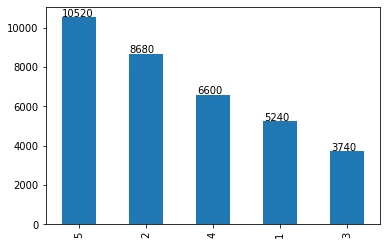

In [27]:
ax = data.zone.value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

In [28]:
# import pickle
# data.to_csv('../content/drive/MyDrive/Colab Notebooks/Kosar/FinalProject/data_with_label_zone_imputed_with_avg.csv', index=False)
# with open('../content/drive/MyDrive/Colab Notebooks/Kosar/FinalProject/avg_per_point.pkl', 'wb') as f:
    # pickle.dump(avg_per_point, f)

# 5. zone prediction

## 1. prepare training data

In [29]:
data.zone.value_counts()

5    10520
2     8680
4     6600
1     5240
3     3740
Name: zone, dtype: int64

In [30]:
final_feature_list = [
                    #   "44:d9:e7:09:ca:66",
                    #   "44:d9:e7:09:ca:cd",
                    #   "44:d9:e7:09:ce:9a",
                    #   "44:d9:e7:09:cf:39",
]
print(data.shape)
# data = data.dropna().drop_duplicates()
print(data.shape)
# data2 = data.replace(-100, np.nan).dropna()
if len(final_feature_list) == 0:
    X = data.drop(['x', 'y', 'zone'], axis=1).reset_index(drop=True)
else:
    X = data.drop(['x', 'y', 'zone'], axis=1).reset_index(drop=True)[final_feature_list]
y = data['zone'].reset_index(drop=True)

(34780, 13)
(34780, 13)


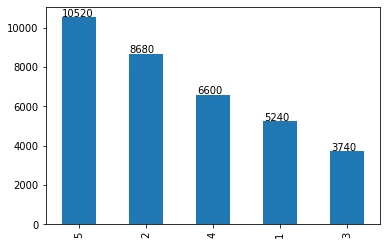

In [31]:
ax = y.value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

In [32]:
# count the samples having null values
is_NaN = X.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = X[row_has_NaN]
rows_with_NaN.shape

(0, 10)

In [33]:
print(X.shape)
print(y.shape)

(34780, 10)
(34780,)


In [34]:
for col in X.columns:
    c = X[col].value_counts().to_dict().get(-100)
    print(col, '==> ',c)

44:d9:e7:09:ca:66 ==>  8535
44:d9:e7:09:ca:cd ==>  1812
44:d9:e7:09:ce:9a ==>  1613
44:d9:e7:09:cf:39 ==>  4023
44:d9:e7:43:3d:fa ==>  18655
46:d9:e7:09:ca:66 ==>  16852
46:d9:e7:09:ca:cd ==>  13444
46:d9:e7:09:ce:9a ==>  12531
46:d9:e7:09:cf:39 ==>  12806
46:d9:e7:43:3d:fa ==>  23384


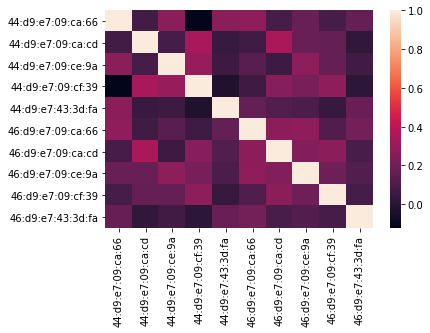

In [35]:
sns.heatmap(X.corr())

In [36]:
random_split = True
if random_split:
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
else:
    test_ratio = 0.75
    cutoff = int(data.shape[0] * test_ratio)
    x_train, x_test = X.iloc[:cutoff], X.iloc[cutoff:]
    y_train,  y_test = y.iloc[:cutoff], y[cutoff:]

## plot classification report function

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title, y=1.25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, accuracy,model_name, number_of_classes=2, title='Classification report ', cmap='RdYlGn'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')
    
    #drop initial lines
    lines = lines[2:]

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[: number_of_classes]:
        t = list(filter(None, line.strip().split('  ')))
        if len(t) < 4: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)


    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 10
    figure_height = len(class_names) + 3
    correct_orientation = True
    title += f'[total accuracy: {accuracy}]'
    title = f'{model_name}\n' + title
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    plt.show()

##2. KNN

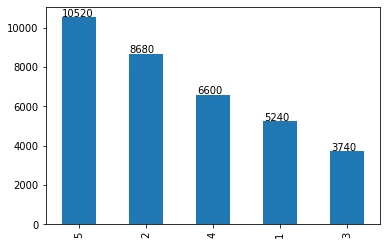

In [39]:
ax = y.value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

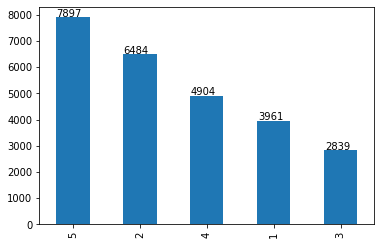

In [40]:
ax = y_train.value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

In [41]:
# resample
resampler = RandomOverSampler(random_state=1)
print('befor resample: \n', y_train.value_counts())
x_train_rsmpl, y_train_rsmpl = resampler.fit_resample(x_train, y_train)
print('after resample: \n',pd.Series(y_train_rsmpl).value_counts())

befor resample: 
 5    7897
2    6484
4    4904
1    3961
3    2839
Name: zone, dtype: int64
after resample: 
 5    7897
4    7897
3    7897
2    7897
1    7897
Name: zone, dtype: int64


https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [42]:
# hypertune
algorithm = KNeighborsClassifier()
# Create 5 folds
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
# Define our candidate hyperparameters
hp_candidates = [{'n_neighbors': [2,3,4,5,6,7,8,9,10], 'weights': ['uniform','distance']}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(x_train_rsmpl, y_train_rsmpl)


# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
0.946713963743426
KNeighborsClassifier(n_neighbors=2, weights='distance')
{'n_neighbors': 2, 'weights': 'distance'}


KNeighborsClassifier
              precision    recall  f1-score   support

           1       0.86      0.91      0.89      1279
           2       0.95      0.88      0.92      2196
           3       0.70      0.82      0.76       901
           4       0.83      0.85      0.84      1696
           5       0.96      0.92      0.94      2623

    accuracy                           0.88      8695
   macro avg       0.86      0.88      0.87      8695
weighted avg       0.89      0.88      0.89      8695



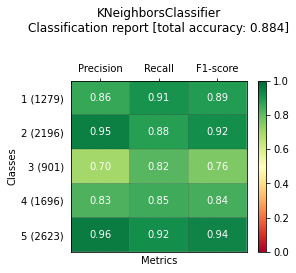

In [43]:
# train and evaluate
knn_model = KNeighborsClassifier()

knn_model.fit(x_train_rsmpl, y_train_rsmpl)
pred = knn_model.predict(x_test)
class_report = classification_report(y_test, pred, output_dict=True)
print(type(knn_model).__name__)
print(classification_report(y_test, pred))
plot_classification_report(classification_report(y_test, pred), round(class_report.get('accuracy'),3),'KNeighborsClassifier', number_of_classes=5)

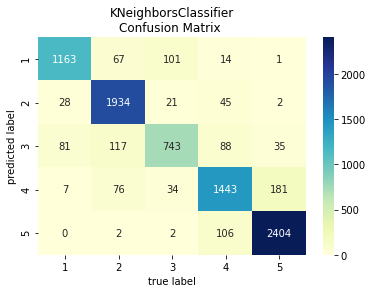

In [44]:
mat = confusion_matrix(y_test, pred)
labels = [1,2,3,4,5]
title = 'KNeighborsClassifier\nConfusion Matrix '
sns.heatmap(mat.T, annot=True, fmt='d', cbar=True, xticklabels=labels,  yticklabels=labels, cmap="YlGnBu")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title(title)
plt.show()

In [45]:
# save
# column_save_name = 'columns.pkl'
# path = f"/content/drive/MyDrive/{column_save_name}"
# with open(path, 'wb') as fid:
#      joblib.dump(list(X.columns), fid)

model_save_name = 'knn_classifier_10f_imp100.pkl'
path = f"{models_dir}{model_save_name}"
with open(path, 'wb') as fid:
    joblib.dump(knn_model, fid)

## 2.1 Test KNN - dead samples

In [46]:
# load model
model_save_name = 'knn_classifier_10f_imp100.pkl'
path = f"{models_dir}{model_save_name}"
with open(path, 'rb') as fid:
   test_model =  joblib.load(fid)

KNeighborsClassifier


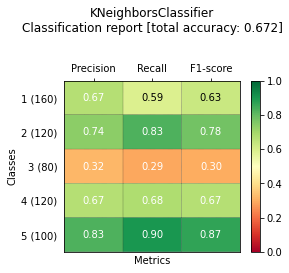

In [50]:
test_model = knn_model

raw_test_data_csv_path = '../content/drive/MyDrive/wifi_project/2021_08_16-22_01_40_modified.csv'
test_data = pd.read_csv(raw_test_data_csv_path).iloc[:,1:]
# remove extra mac addresses [iphone and irancell]
mac_remove = [item for item in mac_remove_list if item not in ['00:1f:fb:ea:46:d9','b8:76:3f:5a:77:4f']]
test_data = test_data.drop(mac_remove, axis=1)
# set date_time column as index,  then sort by date_time
test_data['date_time'] = pd.to_datetime(test_data.date_time)
test_data = test_data.set_index('date_time').sort_index()
test_data = test_data.fillna(-100)
test_data['zone'] = test_data.apply(lambda row:get_zone(row.x, row.y) , axis=1)
test_data = test_data.dropna()
xx_test = test_data.drop(['x', 'y', 'zone'], axis=1).reset_index(drop=True)
yytest = test_data['zone'].reset_index(drop=True)

feature_names = list(x_train.columns)
xx_test = xx_test[feature_names]
pred = test_model.predict(xx_test)
class_report = classification_report(yytest, pred, output_dict=True)
print(type(test_model).__name__)
plot_classification_report(classification_report(yytest, pred), round(class_report.get('accuracy'),3),'KNeighborsClassifier', number_of_classes=5)

##3.Random Forest

In [48]:
resampler = SMOTE(random_state=1)

print('befor resample: \n', y_train.value_counts())
x_train_rsmpl, y_train_rsmpl = resampler.fit_resample(X, y)
# x_train_rsmpl, y_train_rsmpl =X, y
print('after resample: \n',pd.Series(y_train_rsmpl).value_counts())

befor resample: 
 5    7897
2    6484
4    4904
1    3961
3    2839
Name: zone, dtype: int64
after resample: 
 5    10520
4    10520
3    10520
2    10520
1    10520
Name: zone, dtype: int64


https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [53]:
# hypertune
algorithm = RandomForestClassifier()
# Create 5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
# Define our candidate hyperparameters
hp_candidates = [
                 {
                  'max_depth': [10, 20, 30, None],
                  'min_samples_leaf': [1, 2, 4],
                  'n_estimators': [600, 800, 1000]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(x_train_rsmpl, y_train_rsmpl)


# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

RandomForestClassifier
              precision    recall  f1-score   support

           1       0.98      0.98      0.98      1279
           2       0.99      1.00      0.99      2196
           3       0.96      0.96      0.96       901
           4       1.00      0.98      0.99      1696
           5       1.00      0.99      1.00      2623

    accuracy                           0.99      8695
   macro avg       0.98      0.98      0.98      8695
weighted avg       0.99      0.99      0.99      8695



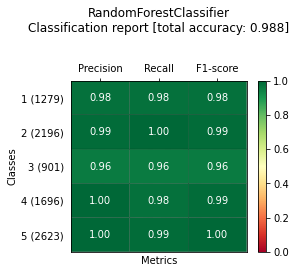

In [52]:
# train and evaluate
random_forest_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

random_forest_model.fit(x_train_rsmpl, y_train_rsmpl)
pred = random_forest_model.predict(x_test)
class_report = classification_report(y_test, pred, output_dict=True)
print(type(random_forest_model).__name__)
print( classification_report(y_test, pred, output_dict=False))
plot_classification_report(classification_report(y_test, pred), round(class_report.get('accuracy'),3),'RandomForestClassifier', number_of_classes=5)

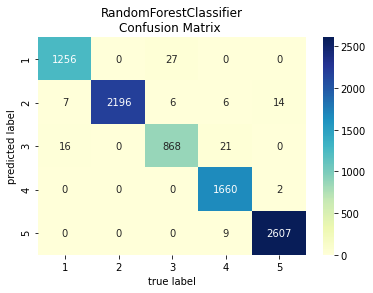

In [54]:
mat = confusion_matrix(y_test, pred)
labels = [1,2,3,4,5]
title = 'RandomForestClassifier\nConfusion Matrix '
sns.heatmap(mat.T, annot=True, fmt='d', cbar=True, xticklabels=labels,  yticklabels=labels, cmap="YlGnBu")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title(title)
plt.show()

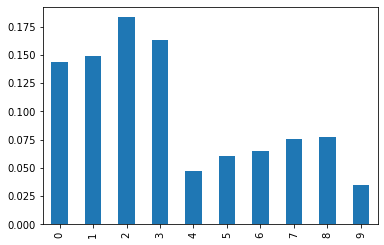

In [55]:
pd.Series(random_forest_model.feature_importances_).plot(kind='bar')

In [56]:
# save
column_save_name = 'columns_rf.pkl'
path = f"/content/drive/MyDrive/{column_save_name}"
with open(path, 'wb') as fid:
     joblib.dump(list(X.columns), fid)

model_save_name = 'random_forest_classifier_10f_imp100.pkl'
path = f"{models_dir}{model_save_name}"
with open(path, 'wb') as fid:
    joblib.dump(random_forest_model, fid, compress = 2)

## 3.1 Test Random Forest - dead samples

In [57]:
# load model
model_save_name =  'random_forest_classifier_10f_imp100.pkl'
path = f"{models_dir}{model_save_name}"
with open(path, 'rb') as fid:
   test_model =  joblib.load(fid)

In [58]:
# load model
# import joblib
# import numpy as np
# model_save_name =  'random_forest_classifier_10f_imp100.pkl'
# models_dir = '../content/drive/MyDrive/FinalProject/models/'
# path = f"{models_dir}{model_save_name}"
# with open(path, 'rb') as fid:
#    test_model =  joblib.load(fid)

# test_sample =np.array( [-67, -47, -45, -60, -100, -69, -48, -45, -62, -75]).reshape(1,- 1)
# test_model.predict(test_sample)

(580, 18)
RandomForestClassifier


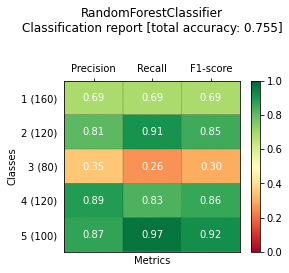

In [59]:
test_model = random_forest_model
drop_nulls = False
raw_test_data_csv_path = '../content/drive/MyDrive/wifi_project/2021_08_16-22_01_40_modified.csv'
test_data = pd.read_csv(raw_test_data_csv_path).iloc[:,1:]
# remove extra mac addresses [iphone and irancell]
mac_remove = [item for item in mac_remove_list if item not in ['00:1f:fb:ea:46:d9','b8:76:3f:5a:77:4f']]
test_data = test_data.drop(mac_remove, axis=1)
# set date_time column as index,  then sort by date_time
test_data['date_time'] = pd.to_datetime(test_data.date_time)
test_data = test_data.set_index('date_time').sort_index()
test_data = test_data.fillna(-100)
test_data['zone'] = test_data.apply(lambda row:get_zone(row.x, row.y) , axis=1)
test_data = test_data.dropna()
if drop_nulls:
    test_data = test_data[list(X.columns)+['x', 'y', 'zone']].replace(-100, np.nan).dropna()
print(test_data.shape)
xx_test = test_data.drop(['x', 'y', 'zone'], axis=1).reset_index(drop=True)
yytest = test_data['zone'].reset_index(drop=True)

feature_names = list(X.columns)
xx_test = xx_test[feature_names]
pred = test_model.predict(xx_test)
class_report = classification_report(yytest, pred, output_dict=True)
print(type(test_model).__name__)
plot_classification_report(classification_report(yytest, pred), round(class_report.get('accuracy'),3),'RandomForestClassifier', number_of_classes=5)

##4. Catboost

In [60]:
# resample
resampler = SMOTE(random_state=1)

print('befor resample: \n', y_train.value_counts())
x_train_rsmpl, y_train_rsmpl = resampler.fit_resample(x_train, y_train)
print('after resample: \n',pd.Series(y_train_rsmpl).value_counts())

befor resample: 
 5    7897
2    6484
4    4904
1    3961
3    2839
Name: zone, dtype: int64
after resample: 
 5    7897
4    7897
3    7897
2    7897
1    7897
Name: zone, dtype: int64


https://catboost.ai/docs/concepts/python-reference_catboostclassifier_randomized_search.html

In [ ]:
# hypertune
# model = CatBoostClassifier(verbose=0, task_type='GPU', loss_function='MultiClass', iterations=1000)
# grid = {'learning_rate': [0.03,0.05, 0.2, 0.25],
#         'depth': [4, 6, 8],
#         'l2_leaf_reg': [1, 3]}
# randomized_search_result = model.randomized_search(grid,
#                                                    X=x_train_rsmpl,
#                                                    y=y_train_rsmpl,
#                                                    plot=False,
#                                                    verbose=2)

CatBoostClassifier
              precision    recall  f1-score   support

           1       0.93      0.91      0.92      1279
           2       0.96      0.94      0.95      2196
           3       0.83      0.89      0.86       901
           4       0.89      0.90      0.90      1696
           5       0.97      0.97      0.97      2623

    accuracy                           0.93      8695
   macro avg       0.92      0.92      0.92      8695
weighted avg       0.93      0.93      0.93      8695



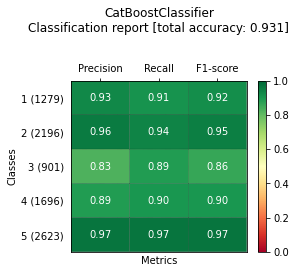

In [61]:
# train and evaluate
catboost_clf_model = CatBoostClassifier(verbose=0,
                                        task_type='GPU',
                                        learning_rate=0.2,
                                        depth=10,
                                        l2_leaf_reg=1,
                                        cat_features=[0,1,2,3,4,5,6,7,8,9])

catboost_clf_model.fit(x_train_rsmpl.astype(int), y_train_rsmpl)
pred = catboost_clf_model.predict(x_test.astype(int))
class_report = classification_report(y_test, pred, output_dict=True)
print(type(catboost_clf_model).__name__)
print( classification_report(y_test, pred, output_dict=False))
plot_classification_report(classification_report(y_test, pred), round(class_report.get('accuracy'),3),'CatBoostClassifier', number_of_classes=5)

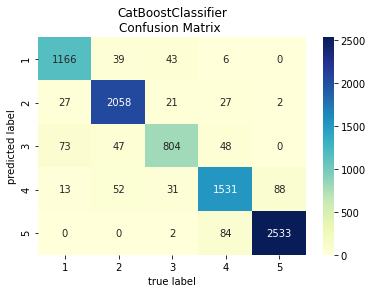

In [62]:
mat = confusion_matrix(y_test, pred)
labels = [1,2,3,4,5]
title = 'CatBoostClassifier\nConfusion Matrix '
sns.heatmap(mat.T, annot=True, fmt='d', cbar=True, xticklabels=labels,  yticklabels=labels, cmap="YlGnBu")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title(title)
plt.show()

In [63]:
# save
model_save_name = 'catboost_classifier_10f_imp100.pkl'
path = f"{models_dir}{model_save_name}"
with open(path, 'wb') as fid:
    joblib.dump(catboost_clf_model, fid, compress = 3)

## 4.1 test catboost - dead samples

In [64]:
# load model
model_save_name =  'catboost_classifier_10f_imp100.pkl'
path = f"{models_dir}{model_save_name}"
with open(path, 'rb') as fid:
   test_model =  joblib.load(fid)

In [66]:
test_model = catboost_clf_model
raw_test_data_csv_path = '../content/drive/MyDrive/wifi_project/2021_08_16-22_01_40_modified.csv'
test_data = pd.read_csv(raw_test_data_csv_path).iloc[:,1:]
# remove extra mac addresses [iphone and irancell]
mac_remove = [item for item in mac_remove_list if item not in ['00:1f:fb:ea:46:d9','b8:76:3f:5a:77:4f']]
test_data = test_data.drop(mac_remove, axis=1)
# set date_time column as index,  then sort by date_time
test_data['date_time'] = pd.to_datetime(test_data.date_time)
test_data = test_data.set_index('date_time').sort_index()
test_data = test_data.fillna(-100)
test_data['zone'] = test_data.apply(lambda row:get_zone(row.x, row.y) , axis=1)
test_data = test_data.dropna()
xx_test = test_data.drop(['x', 'y', 'zone'], axis=1).reset_index(drop=True)
yytest = test_data['zone'].reset_index(drop=True)

feature_names = list(x_train.columns)
xx_test = xx_test[feature_names]
pred = test_model.predict(xx_test)
class_report = classification_report(yytest, pred, output_dict=True)
print(type(test_model).__name__)
plot_classification_report(classification_report(yytest, pred), round(class_report.get('accuracy'),3),'CatBoostClassifier', number_of_classes=5)

##5. xgboost

In [67]:
resampler = SMOTE(random_state=1)

print('befor resample: \n', y_train.value_counts())
x_train_rsmpl, y_train_rsmpl = resampler.fit_resample(x_train, y_train)
print('after resample: \n',pd.Series(y_train_rsmpl).value_counts())

befor resample: 
 5    7897
2    6484
4    4904
1    3961
3    2839
Name: zone, dtype: int64
after resample: 
 5    7897
4    7897
3    7897
2    7897
1    7897
Name: zone, dtype: int64


https://kevinvecmanis.io/machine%20learning/hyperparameter%20tuning/dataviz/python/2019/05/11/XGBoost-Tuning-Visual-Guide.html

In [68]:
##hypertune
# folds = 3
# param_comb = 1    # number of random configurations
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 5, 7, 10],
#         'learning_rate': [0.01, 0.02, 0.05]    
#         }
# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
# xgb = XGBClassifier(learning_rate=0.02, n_estimators=1000, objective='binary:logistic',
#                     silent=True, nthread=6, tree_method='gpu_hist', eval_metric='auc')
# random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(x_train_rsmpl[:100],y_train_rsmpl[:100]), verbose=3, random_state=1001 )
# random_search.fit(x_train_rsmpl[:100], y_train_rsmpl[100])


# print(random_search.best_score_)
# print(random_search.best_estimator_)
# print(random_search.best_params_)

In [70]:
xgboost_clf_model.gamma

XGBClassifier
              precision    recall  f1-score   support

           1       0.95      0.94      0.95      1279
           2       0.97      0.97      0.97      2196
           3       0.88      0.92      0.90       901
           4       0.94      0.92      0.93      1696
           5       0.97      0.98      0.97      2623

    accuracy                           0.95      8695
   macro avg       0.94      0.94      0.94      8695
weighted avg       0.95      0.95      0.95      8695



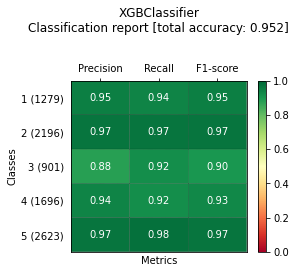

In [71]:
# train and evaluate
xgboost_clf_model = XGBClassifier(task_type='GPU', verbose=0,gamma=0 ,min_child_weight=1, learning_rate=0.3, n_jobs=-1, iterations=2000, max_depth=10, subsample=0.9)

xgboost_clf_model.fit(x_train_rsmpl, y_train_rsmpl)
pred = xgboost_clf_model.predict(x_test)
class_report = classification_report(y_test, pred, output_dict=True)
print(type(xgboost_clf_model).__name__)
print( classification_report(y_test, pred, output_dict=False))
plot_classification_report(classification_report(y_test, pred), round(class_report.get('accuracy'),3),'XGBClassifier', number_of_classes=5)

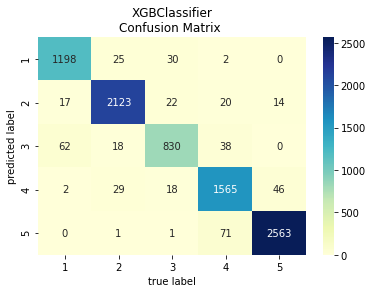

In [72]:
mat = confusion_matrix(y_test, pred)
labels = [1,2,3,4,5]
title = 'XGBClassifier\nConfusion Matrix '
sns.heatmap(mat.T, annot=True, fmt='d', cbar=True, xticklabels=labels,  yticklabels=labels, cmap="YlGnBu")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title(title)
plt.show()

In [73]:
# save
model_save_name = 'xgboost_classifier_10f_imp100.pkl'
path = f"{models_dir}{model_save_name}"
with open(path, 'wb') as fid:
  joblib.dump(xgboost_clf_model, fid, compress = 3)

## 5.1 test xgboost - dead samples

In [77]:
# load model
model_save_name =  'xgboost_classifier_10f_imp100.pkl'
path = f"{models_dir}{model_save_name}"
with open(path, 'rb') as fid:
   test_model =  joblib.load(fid)

XGBClassifier


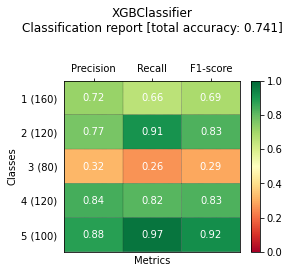

In [78]:
test_model = xgboost_clf_model
raw_test_data_csv_path = '../content/drive/MyDrive/wifi_project/2021_08_16-22_01_40_modified.csv'
test_data = pd.read_csv(raw_test_data_csv_path).iloc[:,1:]
# remove extra mac addresses [iphone and irancell]
mac_remove = [item for item in mac_remove_list if item not in ['00:1f:fb:ea:46:d9','b8:76:3f:5a:77:4f']]
test_data = test_data.drop(mac_remove, axis=1)
# set date_time column as index,  then sort by date_time
test_data['date_time'] = pd.to_datetime(test_data.date_time)
test_data = test_data.set_index('date_time').sort_index()
test_data = test_data.fillna(-100)
test_data['zone'] = test_data.apply(lambda row:get_zone(row.x, row.y) , axis=1)
test_data = test_data.dropna()
xx_test = test_data.drop(['x', 'y', 'zone'], axis=1).reset_index(drop=True)
yytest = test_data['zone'].reset_index(drop=True)

feature_names = list(x_train.columns)
xx_test = xx_test[feature_names]
pred = test_model.predict(xx_test)
class_report = classification_report(yytest, pred, output_dict=True)
print(type(test_model).__name__)
plot_classification_report(classification_report(yytest, pred), round(class_report.get('accuracy'),3),'XGBClassifier', number_of_classes=5)

In [79]:
yytest.value_counts()

1    160
4    120
2    120
5    100
3     80
Name: zone, dtype: int64

https://openclassrooms.com/en/courses/6401081-improve-the-performance-of-a-machine-learning-model/6559796-tune-your-hyperparameters

https://medium.datadriveninvestor.com/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f


## 6. Deep Neural Network

In [80]:
resampler = SMOTE(random_state=1)

print('befor resample: \n', y_train.value_counts())
x_train_rsmpl, y_train_rsmpl = resampler.fit_resample(x_train, y_train)
print('after resample: \n',pd.Series(y_train_rsmpl).value_counts())

befor resample: 
 5    7897
2    6484
4    4904
1    3961
3    2839
Name: zone, dtype: int64
after resample: 
 5    7897
4    7897
3    7897
2    7897
1    7897
Name: zone, dtype: int64


In [81]:
from keras.layers import Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
# model = Sequential()
# model.add(Dense(2, input_dim=10, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [82]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
def plot_history(history):
    if 'mse' in history.history.keys():
        plt.plot(history.history['mse'])
        plt.plot(history.history['val_mse'])
        plt.title('Mean squared error')
        plt.ylabel('Error')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    if 'loss' in history.history.keys():
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('WiFi Localization Data - Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    if 'accuracy' in history.history.keys():
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('WiFi Localization Data - Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

def get_deep_model():
    model = Sequential()
    model.add(Dense(64, activation='sigmoid', input_dim = x_train_rsmpl.shape[1]))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
    return model


def deep_nn2():
    model = Sequential()
    model.add(Dense(50, input_dim=x_train_rsmpl.shape[1], activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(.001), metrics=['accuracy'])
    return model

Epoch 1/1000
66/66 [==============================] - 4s 12ms/step - loss: 1.2114 - accuracy: 0.5171 - val_loss: 1.5468 - val_accuracy: 0.0370
Epoch 2/1000
66/66 [==============================] - 1s 8ms/step - loss: 0.9121 - accuracy: 0.6413 - val_loss: 1.4986 - val_accuracy: 0.2396
Epoch 3/1000
66/66 [==============================] - 1s 8ms/step - loss: 0.8120 - accuracy: 0.6850 - val_loss: 1.2984 - val_accuracy: 0.4918
Epoch 4/1000
66/66 [==============================] - 0s 7ms/step - loss: 0.7399 - accuracy: 0.7121 - val_loss: 1.3737 - val_accuracy: 0.4496
Epoch 5/1000
66/66 [==============================] - 1s 8ms/step - loss: 0.7073 - accuracy: 0.7278 - val_loss: 1.2473 - val_accuracy: 0.4584
Epoch 6/1000
66/66 [==============================] - 1s 8ms/step - loss: 0.6618 - accuracy: 0.7448 - val_loss: 1.2738 - val_accuracy: 0.3699
Epoch 7/1000
66/66 [==============================] - 1s 8ms/step - loss: 0.6430 - accuracy: 0.7542 - val_loss: 1.3984 - val_accuracy: 0.3441
Epoch

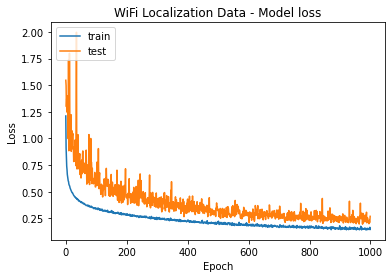

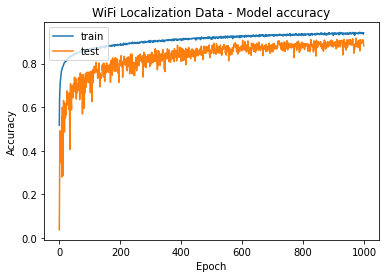

In [83]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.expand_dims(y_train_rsmpl, axis=1))
y_train_onehot = enc.transform(np.expand_dims(y_train_rsmpl, axis=1)).toarray()
y_test_onehot =  enc.transform(np.expand_dims(y_test.values, axis=1)).toarray()

model = get_deep_model()

# train
history = model.fit(x_train_rsmpl, y_train_onehot, validation_split=0.15, epochs=1000, verbose=1, batch_size=512)
plot_history(history)

              precision    recall  f1-score   support

           1       0.87      0.95      0.91      1279
           2       0.94      0.91      0.92      2196
           3       0.81      0.78      0.80       901
           4       0.89      0.81      0.85      1696
           5       0.93      0.97      0.95      2623

    accuracy                           0.90      8695
   macro avg       0.89      0.89      0.89      8695
weighted avg       0.90      0.90      0.90      8695



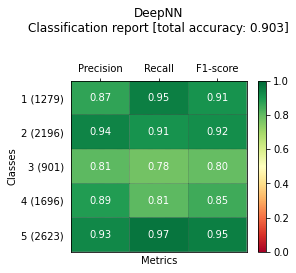

In [84]:
pred = model.predict(x_test.values)
class_report = classification_report(np.argmax(y_test_onehot,axis=1), np.argmax(pred,axis=1), output_dict=True)
print(classification_report(np.argmax(y_test_onehot,axis=1)+1, np.argmax(pred,axis=1)+1))
plot_classification_report(classification_report(np.argmax(y_test_onehot,axis=1)+1, np.argmax(pred,axis=1)+1), round(class_report.get('accuracy'),3),'DeepNN', number_of_classes=5)

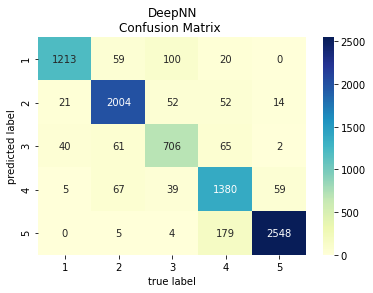

In [85]:
mat = confusion_matrix(np.argmax(y_test_onehot,axis=1)+1, np.argmax(pred,axis=1)+1)
labels = [1,2,3,4,5]
title = 'DeepNN\nConfusion Matrix '
sns.heatmap(mat.T, annot=True, fmt='d', cbar=True, xticklabels=labels,  yticklabels=labels, cmap="YlGnBu")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title(title)
plt.show()

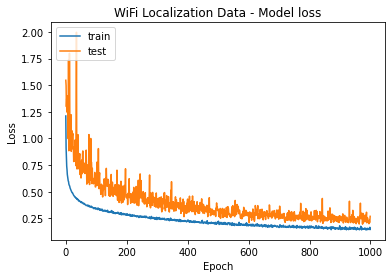

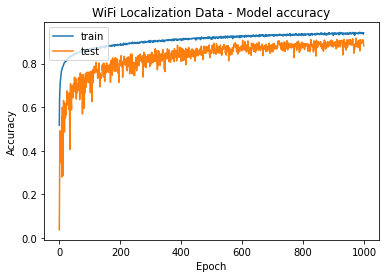

In [86]:
plot_history(history)

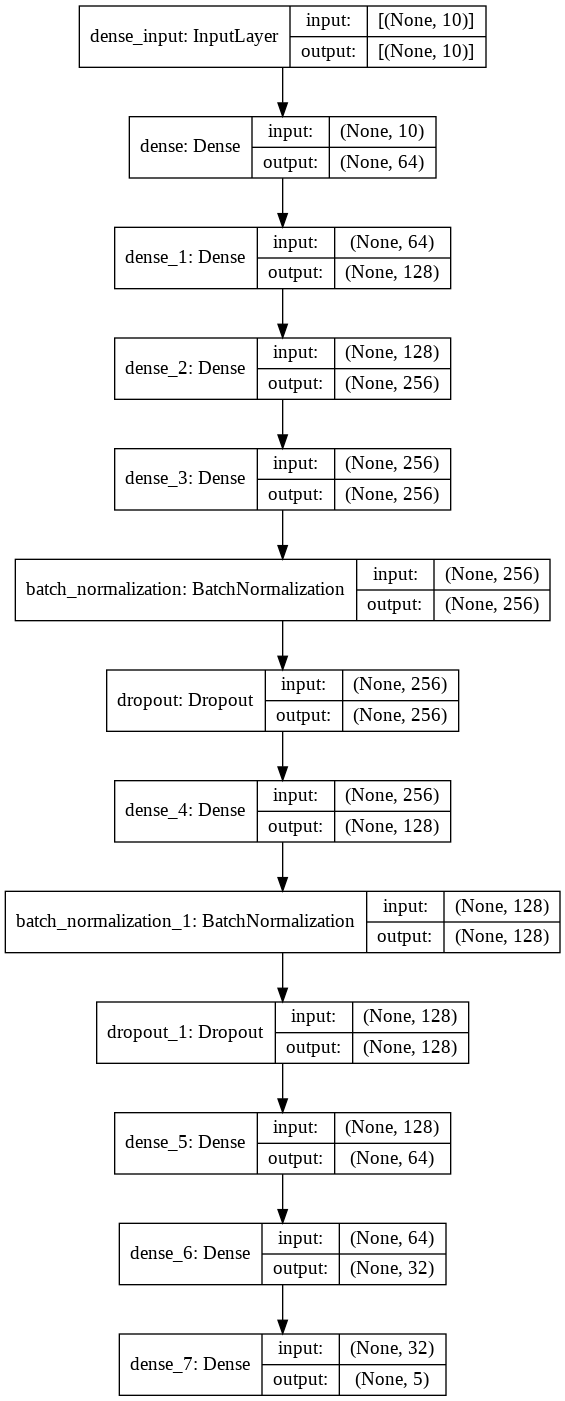

In [87]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# 6. point prediction via multi-label classification

In [88]:
# from sklearn.metrics import hamming_loss,zero_one_loss,coverage_error,label_ranking_loss,average_precision_score
# from sklearn import metrics
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.neighbors import KNeighborsClassifier

## 1. prepare training data

In [89]:
final_feature_list = [
                    #   "44:d9:e7:09:ca:66",
                    #   "44:d9:e7:09:ca:cd",
                    #   "44:d9:e7:09:ce:9a",
                    #   "44:d9:e7:09:cf:39",
]
data = data.dropna()
# data2 = data.replace(-100, np.nan).dropna()
if len(final_feature_list) == 0:
    X = data.drop(['x', 'y', 'zone'], axis=1).reset_index(drop=True)
else:
    X = data.drop(['x', 'y', 'zone'], axis=1).reset_index(drop=True)[final_feature_list]
y = data[['x', 'y']].reset_index(drop=True)

In [90]:
random_split = True
if random_split:
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
else:
    train_ratio = 0.75
    cutoff = int(data.shape[0] * train_ratio)
    x_train, x_test = X.iloc[:cutoff], X.iloc[cutoff:]
    y_train,  y_test = y.iloc[:cutoff], y[cutoff:]

x_train, y_train = x_train.reset_index(drop=True), y_train.reset_index(drop=True)
x_test, y_test = x_test.reset_index(drop=True), y_test.reset_index(drop=True)

## plot functions and test codes

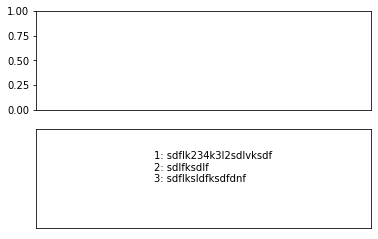

In [91]:
def annotate_dict_in_plot(results, ax):
    string = ''
    for k, v in results.items():
        string += f'{k}: {v}\n'
    ax.annotate(
        string, 
        xy=(0.35, 0.35)
        )
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

fig, ax = plt.subplots(2, 1, sharex=True)
a = {'1':'sdflk234k3l2sdlvksdf', '2':'sdlfksdlf', '3':'sdflksldfksdfdnf'}
annotate_dict_in_plot(a, ax[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


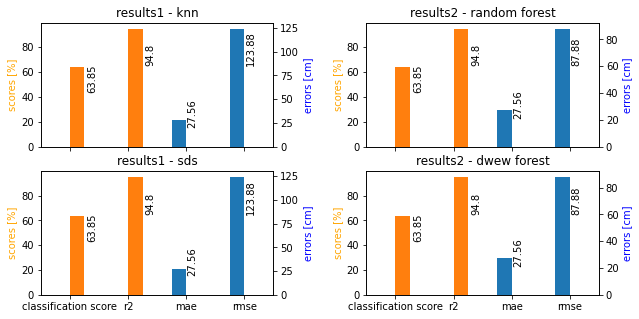

In [92]:
def plot_multilabel_class_results(results, ax, title):
    # errors
    errors = {k:v for k,v in results.items() if k in ['mae','rmse']}
    # scores
    scores = {k:v*100 for k,v in results.items() if k not in ['mae','rmse']}

    df = pd.DataFrame(columns=['errors', 'scores'], index=list(scores.keys())+list(errors.keys()))
    df['scores'] = pd.Series(scores)
    df['errors']  = pd.Series(errors)
    axx = df.plot(kind= 'bar' , secondary_y= 'errors' , rot= 0, legend=False, ax=ax, title=title)
    axx.set_ylabel('scores [%]', c='orange', fontsize=10)
    axx.right_ax.set_ylabel('errors [cm]', c='b', fontsize=10)

    for p in axx.patches:
        if int(p.get_x()) == 2:
            height = round(errors.get('mae'), 2)
            axx.right_ax.annotate(str(height), (p.get_x() * 1.01, height * 0.8), rotation=90)
        elif int(p.get_x()) == 3:
            height = round(errors.get('rmse'), 2)
            axx.right_ax.annotate(str(height), (p.get_x() * 1.01, height * 0.7), rotation=90)
        else:
            height = round(p.get_height(),2)
            axx.annotate(str(height), (p.get_x()+0.3, height *  0.7), rotation=90)


results1 = {'classification score': 0.6385278895917194,
  'r2': 0.9479772510702824,
 'mae': 27.56066705002875,
 'rmse': 123.87544114817732}
results2 = {'classification score': 0.6385278895917194,
 'mae': 27.56066705002875,
 'r2': 0.9479772510702824,
 'rmse': 87.87544114817732}

fig, ax = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(10,5), gridspec_kw={'hspace': 0.2, 'wspace': 0.4})
fig.tight_layout(pad=2.0)
ax = ax.ravel()
plot_multilabel_class_results(results1, ax[0], 'results1 - knn')
plot_multilabel_class_results(results2, ax[1], 'results2 - random forest')
plot_multilabel_class_results(results1, ax[2], 'results1 - sds')
plot_multilabel_class_results(results2, ax[3], 'results2 - dwew forest')

Text(0, 0.5, 'R2 Score [%]')

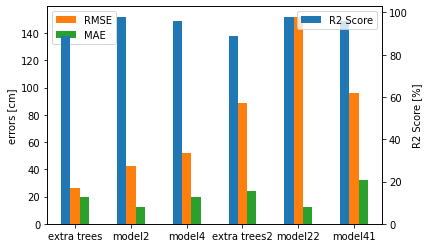

In [93]:
r2_results =  {
    "extra trees":0.89,
    'model2':0.98,
    'model4':0.96,
    "extra trees2":0.89,
    'model22':0.98,
    'model41':0.96
}
rmse_results =  {
    "extra trees":26.5,
    'model2':42.5,
    'model4':52.1,
    "extra trees2":89,
    'model22':152,
    'model41':96
}
mae_results =  {
    "extra trees":20,
    'model2':12,
    'model4':19.5,
    "extra trees2":24,
    'model22':12,
    'model41':32
}

df = pd.DataFrame()
df['R2 Score'] =pd.Series(r2_results) * 100
df['RMSE'] = pd.Series(rmse_results)
df['MAE'] = pd.Series(mae_results)
axx = df.plot(kind= 'bar' , secondary_y= 'R2 Score' , rot= 0, legend=True)
plt.legend(loc='upper right')
axx.legend(loc='upper left')
axx.set_ylabel('errors [cm]', fontsize=10)
axx.right_ax.set_ylabel('R2 Score [%]', fontsize=10)

## KNN

In [94]:
mout_r2  = {}
mout_rmse = {}
mout_mae = {}
mout_hamm = {}

In [95]:
from sklearn.preprocessing import LabelBinarizer
mlbx = LabelBinarizer()
mlby = LabelBinarizer()

In [96]:
mlbx.fit(list(y.values[:,0]))
mlby.fit(list(y.values[:,1]))

LabelBinarizer()

In [97]:
def binarize_labels(label_array):
    label_array_binary_x = mlbx.transform(label_array[:,0])
    label_array_binary_y = mlby.transform(label_array[:,1])
    return np.hstack((label_array_binary_x, label_array_binary_y))

The Hamming loss is upperbounded by the subset zero-one loss, when normalize parameter is set to True. It is always between 0 and 1, lower being better.

In [98]:
knn = KNeighborsClassifier(n_neighbors=3)
classifier = MultiOutputClassifier(knn, n_jobs=-1)
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

# predictions_binary = binarize_labels(predictions)
# y_test_binary = binarize_labels(np.array(y_test))

mout_r2['KNN'] = metrics.r2_score(predictions,np.array(y_test))
mout_rmse['KNN'] = np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
mout_mae['KNN'] = metrics.mean_absolute_error(predictions,np.array(y_test))
# mout_hamm['KNN'] = metrics.hamming_loss(predictions_binary, y_test_binary)

results = {
    # 'Hamming Loss': metrics.hamming_loss(predictions_binary, y_test_binary),
    'RMSE':np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
    'MAE':metrics.mean_absolute_error(predictions,np.array(y_test)),
    'R2 Score' :metrics.r2_score(predictions,np.array(y_test))
}
results

{'MAE': 64.50258769407705,
 'R2 Score': 0.858532578614267,
 'RMSE': 149.44382225170997}

## Random Forest 

In [99]:
rf = RandomForestClassifier()
classifier = MultiOutputClassifier(rf, n_jobs=-1)

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

# predictions_binary = binarize_labels(predictions)
# y_test_binary = binarize_labels(np.array(y_test))

mout_r2['Random Forest'] = metrics.r2_score(predictions,np.array(y_test))
mout_rmse['Random Forest'] = np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
mout_mae['Random Forest'] = metrics.mean_absolute_error(predictions,np.array(y_test))
# mout_hamm['Random Forest'] = metrics.hamming_loss(predictions_binary, y_test_binary)

results = {
    # 'Hamming Loss': metrics.hamming_loss(predictions_binary, y_test_binary),
    'RMSE':np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
    'MAE':metrics.mean_absolute_error(predictions,np.array(y_test)),
    'R2 Score' :metrics.r2_score(predictions,np.array(y_test))
}
results
# plot_multilabel_class_results(results)

{'MAE': 27.68832662449684,
 'R2 Score': 0.9481870992366184,
 'RMSE': 87.96138522327158}

## Decision Tree

In [100]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
classifier = MultiOutputClassifier(dt, n_jobs=-1)

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

# predictions_binary = MultiLabelBinarizer().fit_transform(predictions)
# y_test_binary = MultiLabelBinarizer().fit_transform(np.array(y_test))

mout_r2['Decision Tree'] = metrics.r2_score(predictions,np.array(y_test))
mout_rmse['Decision Tree'] = np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
mout_mae['Decision Tree'] = metrics.mean_absolute_error(predictions,np.array(y_test))
# mout_hamm['Decision Tree'] = metrics.hamming_loss(predictions_binary, y_test_binary)

results = {
    # 'Hamming Loss': metrics.hamming_loss(predictions_binary, y_test_binary),
    'RMSE':np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
    'MAE':metrics.mean_absolute_error(predictions,np.array(y_test)),
    'R2 Score' :metrics.r2_score(predictions,np.array(y_test))
}
results
# plot_multilabel_class_results(results)


{'MAE': 46.33352501437608,
 'R2 Score': 0.9074674366179196,
 'RMSE': 123.91347219388348}

## Extra Tree

In [101]:
from sklearn.tree import ExtraTreeClassifier
et = ExtraTreeClassifier()
classifier = MultiOutputClassifier(et, n_jobs=-1)

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

# predictions_binary = MultiLabelBinarizer().fit_transform(predictions)
# y_test_binary = MultiLabelBinarizer().fit_transform(np.array(y_test))

mout_r2['Extra Tree'] = metrics.r2_score(predictions,np.array(y_test))
mout_rmse['Extra Tree'] = np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
mout_mae['Extra Tree'] = metrics.mean_absolute_error(predictions,np.array(y_test))
# mout_hamm['Extra Tree'] = metrics.hamming_loss(predictions_binary, y_test_binary)

results = {
    # 'Hamming Loss': metrics.hamming_loss(predictions_binary, y_test_binary),
    'RMSE':np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
    'MAE':metrics.mean_absolute_error(predictions,np.array(y_test)),
    'R2 Score' :metrics.r2_score(predictions,np.array(y_test))
}
results
# plot_multilabel_class_results(results)

{'MAE': 49.973548016101205,
 'R2 Score': 0.8812245319909597,
 'RMSE': 133.45706354137153}

## MLPClassifier

In [102]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
classifier = MultiOutputClassifier(mlp, n_jobs=-1)

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

# predictions_binary = MultiLabelBinarizer().fit_transform(predictions)
# y_test_binary = MultiLabelBinarizer().fit_transform(np.array(y_test))

mout_r2['MLP'] = metrics.r2_score(predictions,np.array(y_test))
mout_rmse['MLP'] = np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
mout_mae['MLP'] = metrics.mean_absolute_error(predictions,np.array(y_test))
# mout_hamm['MLP'] = metrics.hamming_loss(predictions_binary, y_test_binary)

results = {
    # 'Hamming Loss': metrics.hamming_loss(predictions_binary, y_test_binary),
    'RMSE':np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
    'MAE':metrics.mean_absolute_error(predictions,np.array(y_test)),
    'R2 Score' :metrics.r2_score(predictions,np.array(y_test))
}
results
# plot_multilabel_class_results(results)

{'MAE': 127.50431282346176,
 'R2 Score': 0.7193434387227768,
 'RMSE': 204.4058135920974}

In [103]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
classifier = MultiOutputClassifier(nb, n_jobs=-1)

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)
print(predictions.shape)

# predictions_binary = MultiLabelBinarizer().fit_transform(predictions)
# y_test_binary = MultiLabelBinarizer().fit_transform(np.array(y_test))

mout_r2['BernoulliNB'] = metrics.r2_score(predictions,np.array(y_test))
mout_rmse['BernoulliNB'] = np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
mout_mae['BernoulliNB'] = metrics.mean_absolute_error(predictions,np.array(y_test))
# mout_hamm['BernoulliNB'] = metrics.hamming_loss(predictions_binary, y_test_binary)

results = {
    # 'Hamming Loss': metrics.hamming_loss(predictions_binary, y_test_binary),
    'RMSE':np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
    'MAE':metrics.mean_absolute_error(predictions,np.array(y_test)),
    'R2 Score' :metrics.r2_score(predictions,np.array(y_test))
}
results
# plot_multilabel_class_results(results)

(8695, 2)


{'MAE': 203.0718803910293,
 'R2 Score': 0.43878457853683545,
 'RMSE': 324.695247925346}

## AdaBoostClassifier

In [104]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier()
classifier = MultiOutputClassifier(adaboost, n_jobs=-1)

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

# predictions_binary = MultiLabelBinarizer().fit_transform(predictions)
# y_test_binary = MultiLabelBinarizer().fit_transform(np.array(y_test))

mout_r2['AdaBoost'] = metrics.r2_score(predictions,np.array(y_test))
mout_rmse['AdaBoost'] = np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
mout_mae['AdaBoost'] = metrics.mean_absolute_error(predictions,np.array(y_test))
# mout_hamm['BernoulliNB'] = metrics.hamming_loss(predictions_binary, y_test_binary)

results = {
    # 'Hamming Loss': metrics.hamming_loss(predictions_binary, y_test_binary),
    'RMSE':np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
    'MAE':metrics.mean_absolute_error(predictions,np.array(y_test)),
    'R2 Score' :metrics.r2_score(predictions,np.array(y_test))
}
results
# plot_multilabel_class_results(results)

{'MAE': 204.74180563542268,
 'R2 Score': 0.5144795778334744,
 'RMSE': 307.910989879099}

## GradientBoostingClassifier

In [105]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
classifier = MultiOutputClassifier(gbc, n_jobs=-1)

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

# predictions_binary = MultiLabelBinarizer().fit_transform(predictions)
# y_test_binary = MultiLabelBinarizer().fit_transform(np.array(y_test))

mout_r2['GradientBoosting'] = metrics.r2_score(predictions,np.array(y_test))
mout_rmse['GradientBoosting'] = np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
mout_mae['GradientBoosting'] = metrics.mean_absolute_error(predictions,np.array(y_test))
# mout_hamm['BernoulliNB'] = metrics.hamming_loss(predictions_binary, y_test_binary)

results = {
    # 'Hamming Loss': metrics.hamming_loss(predictions_binary, y_test_binary),
    'RMSE':np.sqrt(metrics.mean_squared_error(predictions, np.array(y_test))),
    'MAE':metrics.mean_absolute_error(predictions,np.array(y_test)),
    'R2 Score' :metrics.r2_score(predictions,np.array(y_test))
}
results
# plot_multilabel_class_results(results)

{'MAE': 83.26164462334675,
 'R2 Score': 0.8129014854608811,
 'RMSE': 157.8440135226717}

## xgBoost

In [106]:
df

,R2 Score,RMSE,MAE
extra trees,89.0,26.5,20.0
model2,98.0,42.5,12.0
model4,96.0,52.1,19.5
extra trees2,89.0,89.0,24.0
model22,98.0,152.0,12.0
model41,96.0,96.0,32.0


In [107]:
pd.Series(mout_rmse).apply(lambda x: x[0])

KNN                 149.443822
Random Forest        87.961385
Decision Tree       123.913472
Extra Tree          133.457064
MLP                 204.405814
BernoulliNB         324.695248
AdaBoost            307.910990
GradientBoosting    157.844014
dtype: float64

Text(0, 0.5, 'R2 Score [%]')

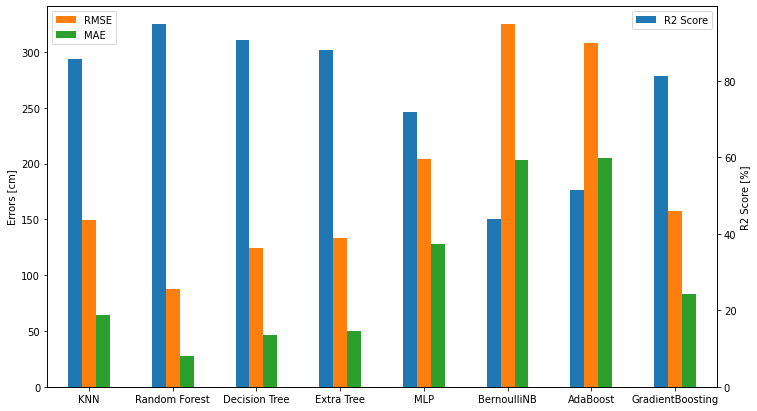

In [108]:
# plot
df = pd.DataFrame()
df['R2 Score'] =pd.Series(mout_r2) * 100
# df['Hamming Loss'] = pd.Series(mout_hamm) * 100
df['RMSE'] = pd.Series(mout_rmse).apply(lambda x: x[0])
df['MAE'] = pd.Series(mout_mae)
axx = df.plot(kind= 'bar' , secondary_y= [
                                          'R2 Score',
                                        #   'Hamming Loss'
                                          ] , rot= 0, legend=True, figsize=(12,7))
plt.legend(loc='upper right')
axx.legend(loc='upper left')
axx.set_ylabel('Errors [cm]', fontsize=10)
axx.right_ax.set_ylabel('R2 Score [%]', fontsize=10)

# 7. point prediction via multi-label regression

In [110]:
# حذف اکسس پوینت هایی که دیتای زیادی از آن جمع آوری نشده است
cut_factor = 1.2  # grater value removes more columns
th = data.shape[0]//cut_factor
data = data.fillna(-100)

for col in data.columns:
#   if data[col].isna().sum() >  th: data.drop(col, axis=1, inplace=True)
    try:
        if data[col].value_counts().get(-100) > th: data.drop(col, axis=1, inplace=True)
    except:
        pass

print(data.shape)
print(data.columns)

(34780, 13)
Index(['x', 'y', '44:d9:e7:09:ca:66', '44:d9:e7:09:ca:cd', '44:d9:e7:09:ce:9a',
       '44:d9:e7:09:cf:39', '44:d9:e7:43:3d:fa', '46:d9:e7:09:ca:66',
       '46:d9:e7:09:ca:cd', '46:d9:e7:09:ce:9a', '46:d9:e7:09:cf:39',
       '46:d9:e7:43:3d:fa', 'zone'],
      dtype='object')


In [113]:
final_feature_list = [
                    #   "44:d9:e7:09:ca:66",
                    #   "44:d9:e7:09:ca:cd",
                    #   "44:d9:e7:09:ce:9a",
                    #   "44:d9:e7:09:cf:39",
]
data = data.dropna()
# data2 = data.replace(-100, np.nan).dropna()
if len(final_feature_list) == 0:
    X = data.drop(['x', 'y','zone'], axis=1).reset_index(drop=True)
else:
    X = data.drop(['x', 'y','zone'], axis=1).reset_index(drop=True)[final_feature_list]
y = data[['x', 'y']].reset_index(drop=True)

In [114]:
random_split = True
if random_split:
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
else:
    train_ratio = 0.75
    cutoff = int(data.shape[0] * train_ratio)
    x_train, x_test = X.iloc[:cutoff], X.iloc[cutoff:]
    y_train,  y_test = y.iloc[:cutoff], y[cutoff:]

x_train, y_train = x_train.reset_index(drop=True), y_train.reset_index(drop=True)
x_test, y_test = x_test.reset_index(drop=True), y_test.reset_index(drop=True)

In [115]:
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=1000, max_depth=100, max_features = 'sqrt', min_samples_leaf = 1),
    "K-nn": KNeighborsRegressor(),                          # Accept default parameters
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(max_depth=4, random_state=2),
    # "Decision Tree Regressor":DecisionTreeRegressor(max_depth=5),
    "MultiO/P GBR" :MultiOutputRegressor(GradientBoostingRegressor(n_estimators=5)),
    "MultiO/P AdaB" :MultiOutputRegressor(AdaBoostRegressor(n_estimators=5)),
    # "Catboost Reggressor": CatBoostRegressor(task_type='GPU', verbose=0),
    # "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor":DecisionTreeRegressor(),
    # "KNeighborsRegressor":KNeighborsRegressor(),
    "MLPRegressor":MLPRegressor(),
    # "RandomForestRegressor":RandomForestRegressor(),
    # "GradientBoostingRegressor":GradientBoostingRegressor(),
    # "GradientBoostingRegressor":SVR(),
    # "XGBRegressor":XGBRegressor()
 }

In [116]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

r2_results = {}
rmse_results = {}
mae_results = {}
for name, estimator in ESTIMATORS.items():    
    estimator.fit(x_train, y_train)
    y_pred = estimator.predict(x_test)
    r2= r2_score(y_test, y_pred)
    print(f'{name} - r2: {r2}')
    r2_results.update({str(name) : r2})
    print(f'{name} - mse: {mean_squared_error(y_test, y_pred)}')
    print(f'{name} - mae: {metrics.mean_absolute_error(y_test, y_pred)}')
    mae_results.update({str(name) : metrics.mean_absolute_error(y_test, y_pred)})
    print(f'{name} - rmse: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
    rmse_results.update({str(name) : np.sqrt(metrics.mean_squared_error(y_test, y_pred))})


Extra trees - r2: 0.958716721046795
Extra trees - mse: 6566.474773294731
Extra trees - mae: 36.77625382783195
Extra trees - rmse: 81.03378784985144
K-nn - r2: 0.8957351435186545
K-nn - mse: 16624.348706152963
K-nn - mae: 75.02449683726279
K-nn - rmse: 128.93544394833006
Linear regression - r2: 0.3562386626634255
Linear regression - mse: 105055.12713642008
Linear regression - mae: 233.10332605228655
Linear regression - rmse: 324.1220867766035
Ridge - r2: 0.3562386419124758
Ridge - mse: 105055.13356315208
Ridge - mae: 233.1033812144772
Ridge - rmse: 324.1220966906639
Lasso - r2: 0.35622383762293275
Lasso - mse: 105055.43824260056
Lasso - mae: 233.10747876500147
Lasso - rmse: 324.1225666975389
ElasticNet - r2: 0.35620112135702736
ElasticNet - mse: 105064.6239276164
ElasticNet - mae: 233.17762661664392
ElasticNet - rmse: 324.1367364672144
RandomForestRegressor - r2: 0.6488861942354357
RandomForestRegressor - mse: 52072.75404454944
RandomForestRegressor - mae: 161.4514358683075
RandomForest

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0, 0.5, 'R2 Score [%]')

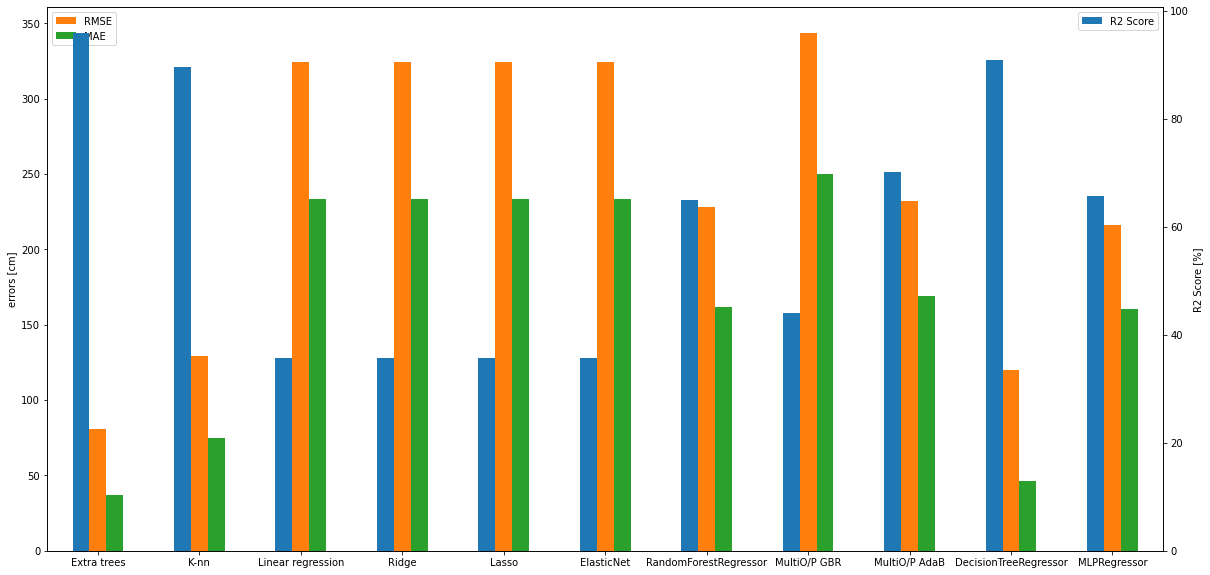

In [117]:
df = pd.DataFrame()
df['R2 Score'] =pd.Series(r2_results) * 100
df['RMSE'] = pd.Series(rmse_results)
df['MAE'] = pd.Series(mae_results)
axx = df.plot(kind= 'bar' , secondary_y= 'R2 Score' , rot= 0, legend=True, figsize = (20, 10))
plt.legend(loc='upper right')
axx.legend(loc='upper left')
axx.set_ylabel('errors [cm]', fontsize=10)
axx.right_ax.set_ylabel('R2 Score [%]', fontsize=10)

## Saving model

In [130]:
import joblib
ml = list(ESTIMATORS.values())[0]
model_save_name = 'Regression_Extratrees_10f_imp100.pkl'
path = f"../content/drive/MyDrive/wifi_project/models/{model_save_name}"
with open(path, 'wb') as fid:
  joblib.dump(ml, fid, compress = 3)

#8. live test

In [120]:
# import live samples from file
import json
live_samples = []
live_samples_path2 = '../content/drive/MyDrive/wifi_project/live_samples_2.txt'
with open(live_samples_path2, 'r') as file:
    lines = file.readlines()
for sample in lines:
    try:
        live_samples.append(json.loads(sample))
    except: pass

In [121]:
# load classification model
model_save_name =  'random_forest_classifier_10f_imp100.pkl'
path = f"{models_dir}{model_save_name}"
with open(path, 'rb') as fid:
   live_test_model =  joblib.load(fid)

In [132]:
# load regression model
model_save_name =  'Regression_Extratrees_10f_imp100.pkl'
path = f"{models_dir}/{model_save_name}"
with open(path, 'rb') as fid:
   live_test_model =  joblib.load(fid)

In [ ]:
live_test_model =  random_forest_model

In [123]:
feature_names = list(x_train.columns)
def process_sample(sample):
    ap = sample.get('accessPoints')
    x_ =  sample.get('x')
    y_ =  sample.get('y')
    rssi_values = [-100 if ap.get(feature) is None else ap.get(feature)  for feature in feature_names]
    return (rssi_values, sample.get('tile'), x_, y_)

# test function
process_sample(live_samples[0])

([-67, -47, -45, -60, -100, -69, -48, -45, -62, -75], 3, 440, 120)

## zone prediction

In [124]:
counter = 1
nice = 0
for sample in live_samples:
    sample = process_sample(sample)
    x = np.array(sample[0]).reshape(1,-1)
    y_true = sample[1]
    print(f'test {counter}:  x = {x} ==> prediction: {live_test_model.predict(x.reshape(1, -1))}  <==>  true: {y_true}')
    if live_test_model.predict(x.reshape(1, -1))[0] == y_true: nice += 1
    counter += 1
print('total accuracy ratio: ', nice / counter)

test 1:  x = [[ -67  -47  -45  -60 -100  -69  -48  -45  -62  -75]] ==> prediction: [2]  <==>  true: 3
test 2:  x = [[ -67  -49  -45  -60 -100  -69  -48  -45  -62  -75]] ==> prediction: [2]  <==>  true: 3
test 3:  x = [[-64 -45 -43 -54 -75 -69 -48 -45 -62 -75]] ==> prediction: [3]  <==>  true: 3
test 4:  x = [[-64 -44 -44 -53 -75 -69 -48 -44 -53 -75]] ==> prediction: [3]  <==>  true: 3
test 5:  x = [[-64 -45 -44 -57 -75 -66 -48 -44 -53 -75]] ==> prediction: [3]  <==>  true: 4
test 6:  x = [[-62 -45 -47 -59 -79 -66 -48 -50 -60 -75]] ==> prediction: [2]  <==>  true: 4
test 7:  x = [[-62 -55 -49 -63 -74 -66 -55 -50 -60 -75]] ==> prediction: [2]  <==>  true: 2
test 8:  x = [[-62 -59 -47 -62 -74 -66 -62 -47 -62 -75]] ==> prediction: [2]  <==>  true: 2
test 9:  x = [[-72 -54 -52 -61 -76 -66 -62 -54 -63 -75]] ==> prediction: [2]  <==>  true: 2
test 10:  x = [[-72 -54 -50 -62 -76 -66 -56 -54 -63 -75]] ==> prediction: [2]  <==>  true: 2
test 11:  x = [[-72 -54 -48 -62 -76 -74 -55 -54 -63 -80]] =

## points prediction

In [ ]:
counter = 1
sum = 0
for sample in live_samples:
    sample = process_sample(sample)
    x = np.array(sample[0]).reshape(1,-1)
    y_true = sample[2:]
    print(f'test {counter}:  x = {x} ==> prediction: {live_test_model.predict(x.reshape(1, -1))}  <==>  true: {y_true}')
    sum += pow(live_test_model.predict(x.reshape(1, -1))[0][1] -y_true[1],2)
    counter += 1
print('RMSE(x): ', sum / counter)

test 1:  x = [[ -67  -47  -45  -60 -100  -69  -48  -45  -62  -75]] ==> prediction: [[753.99       237.57384615]]  <==>  true: (440, 120)
test 2:  x = [[ -67  -49  -45  -60 -100  -69  -48  -45  -62  -75]] ==> prediction: [[756.66 282.64]]  <==>  true: (400, 0)
test 3:  x = [[-64 -45 -43 -54 -75 -69 -48 -45 -62 -75]] ==> prediction: [[751.65 166.19]]  <==>  true: (480, 40)
test 4:  x = [[-64 -44 -44 -53 -75 -69 -48 -44 -53 -75]] ==> prediction: [[585.12 201.27]]  <==>  true: (560, 80)
test 5:  x = [[-64 -45 -44 -57 -75 -66 -48 -44 -53 -75]] ==> prediction: [[678.57 190.68]]  <==>  true: (720, 80)
test 6:  x = [[-62 -45 -47 -59 -79 -66 -48 -50 -60 -75]] ==> prediction: [[750.75 185.07]]  <==>  true: (320, 440)
test 7:  x = [[-62 -55 -49 -63 -74 -66 -55 -50 -60 -75]] ==> prediction: [[891.54 292.86]]  <==>  true: (400, 360)
test 8:  x = [[-62 -59 -47 -62 -74 -66 -62 -47 -62 -75]] ==> prediction: [[941.46487912 303.92657143]]  <==>  true: (520, 400)
test 9:  x = [[-72 -54 -52 -61 -76 -66 -6

# links and references



*   https://github.com/sharan-naribole/wlan_localization
*   List item

